In [1]:
!git clone https://github.com/misbah4064/human-pose-estimation-opencv.git
%cd human-pose-estimation-opencv/

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (20/20), 10.09 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/human-pose-estimation-opencv


In [2]:
import cv2
import numpy as np
import os

from google.colab import drive
drive.mount('/content/drive')


#Path to dataset
dataset_path = '/content/drive/My Drive/dataset2/dataset/'


#Augmentation on images
def augment_images(images, output_folder):
    augmented_images = []
    for img in images:
        #Rotate
        rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        augmented_images.append(rotated_img)

        #Flip horizontally
        flipped_img = cv2.flip(img, 1)
        augmented_images.append(flipped_img)

        #Scale the img
        scaled_img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
        augmented_images.append(scaled_img)

    #Save augmented images
    for idx, augmented_img in enumerate(augmented_images):
        cv2.imwrite(os.path.join(output_folder, f"augmented_{idx}.png"), augmented_img)


#Load imgs (sitting folder)
sitting_images_png = [cv2.imread(os.path.join(dataset_path, "sitting", filename))
                      for filename in os.listdir(os.path.join(dataset_path, "sitting"))
                      if filename.endswith(".png")]

sitting_images_jpg = [cv2.imread(os.path.join(dataset_path, "sitting", filename))
                      for filename in os.listdir(os.path.join(dataset_path, "sitting"))
                      if filename.endswith(".jpg")]

#Combine png, jpg
sitting_images = sitting_images_png + sitting_images_jpg

#Load imgs (standing folder)
standing_images_png = [cv2.imread(os.path.join(dataset_path, "standing", filename))
                       for filename in os.listdir(os.path.join(dataset_path, "standing"))
                       if filename.endswith(".png")]

standing_images_jpg = [cv2.imread(os.path.join(dataset_path, "standing", filename))
                       for filename in os.listdir(os.path.join(dataset_path, "standing"))
                       if filename.endswith(".jpg")]

#Combine png, jpg
standing_images = standing_images_png + standing_images_jpg

#Define the output folder for augmented images
output_folder = '/content/drive/My Drive/dataset2/augmented/'


augment_images(sitting_images, output_folder)
augment_images(standing_images, output_folder)

#Display the number of augmented images
print("Number of augmented sitting images:", len(sitting_images) * 3)
print("Number of augmented standing images:", len(standing_images) * 3)


Mounted at /content/drive
Number of augmented sitting images: 99
Number of augmented standing images: 90


In [32]:
import cv2
import numpy as np
import os

def load_images_and_detect_keypoints():
    #Load the pose detection model
    net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")

    #Defining body parts and pose pairs
    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                   "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                   ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

    #Function for pose detection and feature extraction
    def detect_keypoints(image):
        frameWidth = image.shape[1]
        frameHeight = image.shape[0]
        thr = 0.2

        net.setInput(cv2.dnn.blobFromImage(image, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
        out = net.forward()
        out = out[:, :19, :, :]

        keypoints = []
        for i in range(len(BODY_PARTS)):
            #Slice heatmap of corresponding body part
            heatMap = out[0, i, :, :]

            _, conf, _, point = cv2.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]
            keypoints.append((int(x), int(y)) if conf > thr else None)

        return keypoints

    #Load images from dataset
    def load_images_from_folder(folder):
        images = []
        for filename in os.listdir(folder):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
        return images

    #Augment images and detect keypoints
    def augment_and_detect(images):
        augmented_images = []
        augmented_keypoints = []
        for img in images:
            #Augment the image
            rotated_img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            flipped_img = cv2.flip(img, 1)
            scaled_img = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)

            #Detect keypoints for original and augmented images
            keypoints_original = detect_keypoints(img)
            keypoints_rotated = detect_keypoints(rotated_img)
            keypoints_flipped = detect_keypoints(flipped_img)
            keypoints_scaled = detect_keypoints(scaled_img)

            #Append original and augmented images and keypoints
            augmented_images.extend([img, rotated_img, flipped_img, scaled_img])
            augmented_keypoints.extend([keypoints_original, keypoints_rotated, keypoints_flipped, keypoints_scaled])

        return augmented_images, augmented_keypoints

    dataset_path = '/content/drive/My Drive/dataset2/dataset/'

    #Load images
    sitting_images = load_images_from_folder(os.path.join(dataset_path, "sitting"))
    standing_images = load_images_from_folder(os.path.join(dataset_path, "standing"))

    #Augment images and detect keypoints
    sitting_images_augmented, sitting_keypoints_augmented = augment_and_detect(sitting_images)
    standing_images_augmented, standing_keypoints_augmented = augment_and_detect(standing_images)

    #Number of detected keypoints for each image
    print("Number of keypoints detected in sitting images:", len(sitting_keypoints_augmented[0]))
    print("Number of keypoints detected in standing images:", len(standing_keypoints_augmented[0]))

    return sitting_images_augmented, standing_images_augmented, sitting_keypoints_augmented, standing_keypoints_augmented

#Calling the function
sitting_images, standing_images, sitting_keypoints, standing_keypoints = load_images_and_detect_keypoints()

#Now we can use sitting_images, standing_images, sitting_keypoints, standing_keypoints in other sections


Number of keypoints detected in sitting images: 19
Number of keypoints detected in standing images: 19


In [47]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#Maximum length of keypoints
max_keypoints = 19

#Pad or truncate the sequences to the maximum length
def pad_or_truncate_keypoints(keypoints):
    padded_keypoints = []
    for kp in keypoints:
        if kp is None:
            #If keypoints are None, append zeros to represent missing keypoints
            padded_kp = [[0, 0]] * max_keypoints
        else:
            flat_kp = [coord for point in kp if point is not None for coord in point]  #Flatten the list of tuples
            padded_kp = flat_kp[:max_keypoints * 2] + [0] * ((max_keypoints * 2) - len(flat_kp))
        padded_keypoints.append(padded_kp)
    return np.array(padded_keypoints)

#Pad or truncate the keypoints for sitting and standing images
sitting_keypoints_padded = pad_or_truncate_keypoints(sitting_keypoints)
standing_keypoints_padded = pad_or_truncate_keypoints(standing_keypoints)

#Combine sitting and standing keypoints and labels
X = np.concatenate((sitting_keypoints_padded, standing_keypoints_padded), axis=0)
y = np.array([0] * len(sitting_keypoints_padded) + [1] * len(standing_keypoints_padded))  #0 for sitting, 1 for standing

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(max_keypoints, 2)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  #dropout regularization
    Dense(1, activation='sigmoid')  #Binary classification output
])

#Compile the model
optimizer = Adam(learning_rate=0.001)  #Adam optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#Define early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#Reshape X_train and X_test for CNN input
X_train = X_train.reshape(X_train.shape[0], max_keypoints, 2)
X_test = X_test.reshape(X_test.shape[0], max_keypoints, 2)

#Train the model with early stopping
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
7/7 [==============================] - 1s 46ms/step - loss: 9.9868 - accuracy: 0.5572 - val_loss: 5.0737 - val_accuracy: 0.7255
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 7.6848 - accuracy: 0.6418 - val_loss: 4.9802 - val_accuracy: 0.5490
Epoch 3/20
7/7 [==============================] - 0s 13ms/step - loss: 5.0378 - accuracy: 0.6965 - val_loss: 4.6793 - val_accuracy: 0.6667
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 3.1820 - accuracy: 0.7065 - val_loss: 2.6935 - val_accuracy: 0.5882
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 2.4273 - accuracy: 0.7065 - val_loss: 2.5944 - val_accuracy: 0.7255
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 1.9934 - accuracy: 0.7264 - val_loss: 1.9385 - val_accuracy: 0.7255
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 1.3231 - accuracy: 0.7463 - val_loss: 1.3865 - val_accuracy: 0.6275
Epoch 8/20
7/7 [===========

In [48]:
# Save the trained model
model.save("my_model.h5")

1/1 [==============================] - 0s 90ms/step
Prediction for test1.png: Standing


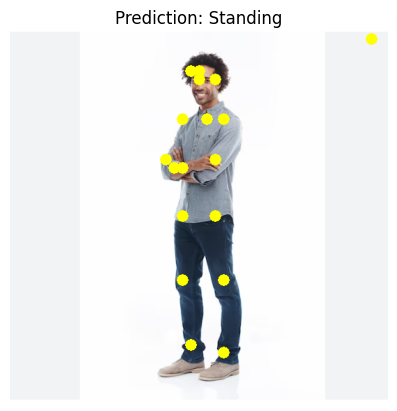

1/1 [==============================] - 0s 21ms/step
Prediction for test2.png: Sitting


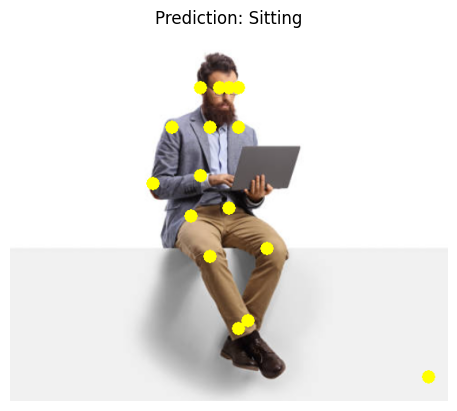

1/1 [==============================] - 0s 21ms/step
Prediction for test3.png: Standing


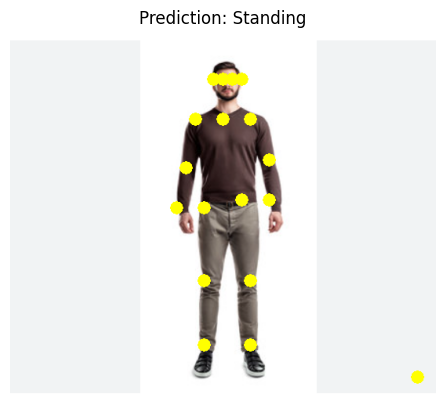

1/1 [==============================] - 0s 20ms/step
Prediction for test4.png: Sitting


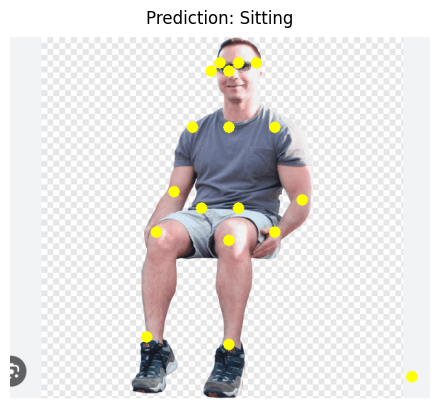

1/1 [==============================] - 0s 24ms/step
Prediction for test5.png: Sitting


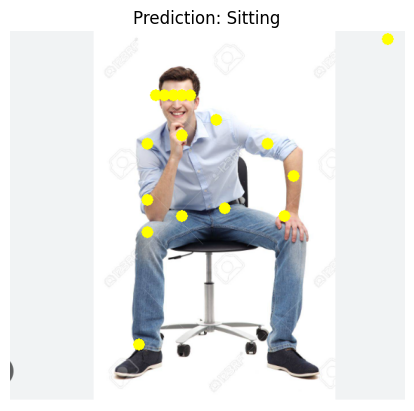

In [50]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

model = load_model('my_model.h5')

max_keypoints = 19

net = cv2.dnn.readNetFromTensorflow("graph_opt.pb")

#Define the body parts and pose pairs for keypoints detection
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

#Function to preprocess the image and extract keypoints
def preprocess_image(image_path):
    #Read the image using OpenCV
    image = cv2.imread(image_path)

    #Check if the image is empty
    if image is None:
        print(f"Error: Unable to read the image '{image_path}'")
        return None, None

    keypoints, image_with_keypoints = detect_keypoints(image)
    padded_keypoints = pad_or_truncate_keypoints([keypoints])

    return image_with_keypoints, padded_keypoints

#Function to detect keypoints using the pre-trained pose estimation model
def detect_keypoints(image):
    frameWidth = image.shape[1]
    frameHeight = image.shape[0]
    thr = 0.2

    net.setInput(cv2.dnn.blobFromImage(image, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    keypoints = []
    image_with_keypoints = image.copy()
    for i in range(len(BODY_PARTS)):
        #Slice heatmap of corresponding body part
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        keypoints.append((int(x), int(y)) if conf > thr else None)

        #Draw keypoints on the image
        if conf > thr:
            cv2.circle(image_with_keypoints, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)

    return keypoints, image_with_keypoints

#Function to pad or truncate keypoints
def pad_or_truncate_keypoints(keypoints):
    padded_keypoints = []
    for kp in keypoints:
        if kp is None:
            padded_kp = [[0, 0]] * max_keypoints
        else:
            flat_kp = [coord for point in kp if point is not None for coord in point]
            padded_kp = flat_kp[:max_keypoints * 2] + [0] * ((max_keypoints * 2) - len(flat_kp))
        padded_keypoints.append(padded_kp)
    return np.array(padded_keypoints)

#test img folder
folder_path = '/content/drive/My Drive/testimg/'
image_filenames = ['test1.png', 'test2.png', 'test3.png', 'test4.png', 'test5.png']

for filename in image_filenames:
    #Preprocess the image and extract keypoints
    image_path = os.path.join(folder_path, filename)
    image_with_keypoints, preprocessed_keypoints = preprocess_image(image_path)

    #Check if image and keypoints are not None
    if image_with_keypoints is not None and preprocessed_keypoints is not None:
        #Reshape preprocessed keypoints for CNN input
        preprocessed_keypoints = preprocessed_keypoints.reshape(1, max_keypoints, 2, 1)
        #Predict using the model
        prediction = model.predict(preprocessed_keypoints)
        print(f"Prediction for {filename}:", "Standing" if prediction[0][0] > 0.5 else "Sitting")

        #Output the processed image with keypoints
        plt.imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Prediction: " + ("Standing" if prediction[0][0] > 0.5 else "Sitting"))
        plt.show()
